# About the notebook
This notebook is designed to train a deep learning UNET architecture for segmenting and detecting structures in a 2D input image. The [UNET architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a popular choice for image segmentation tasks and it is composed of an encoder path, which extracts high-level features, and a decoder path, which takes the features extracted by the encoder path and generates.

The notebook is intended to be user-friendly, intuitive and does not require any programming skills to train the model. The user only needs to provide a training set consisting of input images and their corresponding target masks (also called ground truth images). The input images represent the images that will be segmented, while the target images contain the desired segmentation mask for each input image.

**Training dataset requirements:** To use the notebook, the user needs to provide the paths of the folders containing the input and target images. These folders should be organized in such a way that each input image has a corresponding target image with the same file name. For example, if the input image is named "image_001.tif", then the corresponding target image should be named "image_001_target.tif". **Please note that the current version of the notebook only accepts images in the TIF file format**. 
<br> *The input image* is required to be in a specific shape, which is \[C1,H,W\], where C1 is the number of channels, and H and W are the height and width of the image, respectively. This means that if the input image contains multiple channels, such as a RGB image, the channels should be included in a single file in the specified shape. 
<br> *The target image* should have the shape \[C2,H,W\], where C2 corresponds to the different objects to be segmented. The target image should be a binary image, where each object to be segmented is represented by a separate binary mask. The value of 1 in the mask corresponds to the object to be detected, and 0 corresponds to the background. It is important to note that the number of channels in the input image and the number of objects to segment in the target image may vary depending on the specific task and the dataset being used.

Once the model is trained, the notebook "Predict_Using_Model.ipynb" can be used to generate segmentation masks for new input images. This can be done by providing a new set of input images and running the trained model on these images.

# 00 - Special Instructions for Google Colab Users
The following lines of code should be executed only when running your script on Google Colab. This is crucial to leverage the additional features provided by Colab, most notably, the availability of a free GPU. **If, you're running the code locally, this line can be skipped (GO TO STEP 01 - Loading dependencies) as it pertains specifically to the Colab setup.**

# Give access to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install Napari

In [ ]:
!pip install napari

# Copy code to current session

In [ ]:
!git clone https://github.com/paul-hernandez-herrera/unet_pytorch_2d
import os
workbookDir = "/content/unet_pytorch_2d/"
os.chdir(workbookDir)

# 01 - Loading dependencies
In this notebook, before running any code, there are several libraries and modules that need to be imported to ensure that the notebook runs smoothly. These libraries and modules contain pre-written code that performs specific tasks, such as reading and processing images, defining the UNET model, and training the model.

In [1]:
import os
if 'workbookDir' not in globals():
    print('Updating working directory')
    workbookDir = os.path.dirname(os.getcwd())
    os.chdir(workbookDir)
print(os.getcwd())

import numpy as np
import time
from core_code.util.deeplearning_util import get_model_outputdir, get_batch_size, get_model, load_model,calculate_test_performance,get_dataloader_file_names
from core_code.util.util import write_list_to_file
from core_code.util.show_image import show_images_from_Dataset
from core_code.predict import predict_model
from core_code.datasets.Dataset import CustomImageDataset
from core_code.models.UNet2d_model import Classic_UNet_2D
from core_code.train import train_model
from core_code.parameters_interface.parameters_widget import parameters_model_training_segmentation, parameters_folder_path ,parameters_training_images, parameters_device, parameters_data_augmentation
from core_code.parameters_interface.ipwidget_basic import set_Int
from core_code.parameters_interface import options
from torch.utils.data import DataLoader
from torch import optim
from pathlib import Path

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

Updating working directory
C:\Users\paulh\Documents\github\unet_pytorch_2d


# 02 - Setting required paths of training set
In this section, the user can specify the paths to the training set by specification the folders containing the input images and their corresponding target masks. This is done by setting two parameters: the "Folder path input images" and the "Folder path target mask".

## Required parameters
**Folder path input images**: the path of the folder containing the input images for the training set.

**Folder path target mask**: the path of the folder containing the corresponding target masks for the input images.

In [2]:
parameters_training_set = parameters_training_images()

------------------------------
REQUIRED PARAMETERS
------------------------------


Text(value='', description='Folder path input images:', layout=Layout(flex='1 1 auto', width='auto'), placehol…

Text(value='', description='Folder path target mask:', layout=Layout(flex='1 1 auto', width='auto'), placehold…

# 03 - Visualizing samples from training set
This section is designed to help the user gain a better understanding of the input and target images in the training set. By visualizing these samples, the user can confirm that the images are properly paired and that the target masks accurately represent the structures to be detected in the input images.

Number of samples in training set: 30


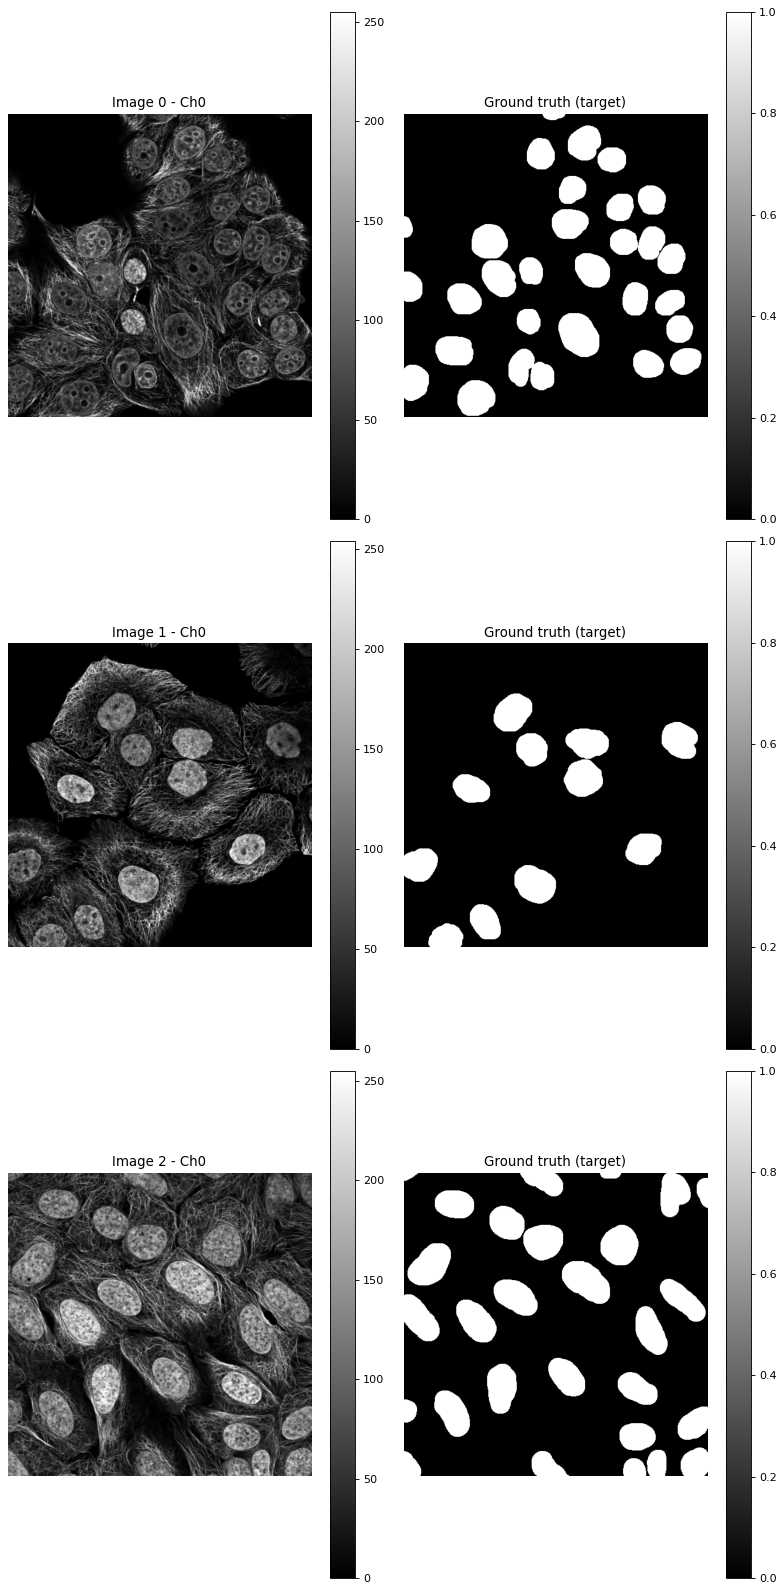

In [3]:
training_dataset = CustomImageDataset(parameters_training_set.get()["folder_input"], parameters_training_set.get()["folder_target"])
print('Number of samples in training set: ' + str(len(training_dataset)))
show_images_from_Dataset(training_dataset)

# 04 - Data augmentation
Data augmentation is a technique commonly used in machine learning to increase the size and variability of a training set by applying various transformations to the original data. These transformations may include flips, rotations, zooms, and shears, among others. The goal of data augmentation is to provide the model with additional training data that captures different variations of the same object, thereby improving the model's ability to generalize to new datasets.

In cases where the training set is relatively small or contains limited variations, data augmentation can be especially useful. By increasing the variability of the training set, data augmentation helps to prevent the model from overfitting to the limited training data and producing inaccurate results on new datasets.

In this notebook, users have the option to enable or disable data augmentation by selecting the appropriate flag. When disabled, the original training images are used without any transformations.

In [4]:
parameters_augmentation = parameters_data_augmentation()

## Visualizing samples of augmented images
After enabling data augmentation in the notebook, users may want to visualize how the transformed images look like. The "Display sample of augmented images" section provides users with an option to visualize the augmented images in order to assess the effectiveness of the data augmentation process. By visualizing these images, users can determine if the data augmentation process is appropriate and if it is achieving the desired variability in the training set.


In [5]:
if parameters_augmentation.get()["enable_data_augmentation"]:
    training_dataset.set_data_augmentation(parameters_augmentation.get()["enable_data_augmentation"], 
                                           options.get_data_augmentation(parameters_augmentation.get()))
    show_images_from_Dataset(training_dataset)
else:
    training_dataset.set_data_augmentation(parameters_augmentation.get()["enable_data_augmentation"])
    print('Data augmentation disable') 

Data augmentation disable


# 05 - Setting important parameters
Deep learning models consists of millions of parameters that need to be optimized to achieve accurate segmentation results.
During the training process, the model learns to optimize its parameters to minimize a loss function, which measures the difference between the predicted segmentation and the ground truth segmentation. The optimization process requires defining several important parameters, including: 
<br>**Device**: *Select the device CPU or GPU (if available)*. The fact that the U-Net model consists of millions of parameters means that the optimization process can be computationally expensive and time-consuming. However, with the advent of specialized hardware, such as GPUs and TPUs, deep learning practitioners can accelerate the optimization process and train large models like U-Net in a reasonable amount of time.
<br>**Model output:** the folder path where the trained model will be stored for future use.
<br>**number of epochs:**  This parameter specifies the number of times the entire dataset is processed during the training process. Setting an appropriate number of epochs  is important to ensure that the model converges to an optimal solution
<br>**validation:** This parameter specifies a separate dataset that is used to evaluate the performance of the model during the training process. The validation dataset is typically used to monitor the progress of the model.
<br>**loss function:** This parameter specifies the function used to measure the difference between the predicted outputs and the ground truth labels.
<br>**optimizer:** This parameter specifies the optimization algorithm used to update the model parameters during training. 


## Setting parameters required to train the model
You can set all the previously describe parameters using the following interface.

In [6]:
img, target  = training_dataset.__getitem__(0)
n_channels_input  = img.shape[0]
n_channels_target = target.shape[0]

parameters_model = parameters_model_training_segmentation(n_channels_target)

------------------------------
    REQUIRED PARAMETERS     
------------------------------


Dropdown(description='Device: ', options=(('NVIDIA GeForce RTX 4090', 'cuda:0'), ('CPU', 'cpu')), style=Descri…

------------------------------
     OPTIONAL PARAMETERS     
------------------------------


IntText(value=100, description='Number of epochs: ', layout=Layout(flex='1 1 auto', width='auto'), style=Descr…

------------------------------


Dropdown(description='Loss function: ', options=(('Dice + BCE', 'dice_BCE'), ('Binary cross entropy (BCE)', 'B…

------------------------------


Dropdown(description='Optimizer: ', options=(('Adam', 'Adam'), ('Nesterov_Adam', 'Nesterov_Adam'), ('Stochasti…

------------------------------


Dropdown(description='learning rate (LR) schedulers: ', options=(('reduce LR on plateau', 'reduce_on_plateau')…

------------------------------


Dropdown(description='Validation :', options=(('% of training set', 'percentage_training_set'), ('None', 'None…

------------------------------


Dropdown(description='Test :', options=(('None', 'None'), ('% of training set', 'percentage_training_set'), ('…

VBox()

## Setting Batch size
<br>**batch size:** the number of images to be use per iteration to compute the gradient.  It is often recommended to use the largest batch size possible that can fit in the available memory without causing an out-of-memory error.

**We provide the following batch size for your computer specifications**

In [7]:
img, target  = training_dataset.__getitem__(0)
batch_size = get_batch_size(model_type = 'unet_2d',
                            device = parameters_model.get('device'),
                            input_shape = (img.shape[0], img.shape[1],img.shape[2]),
                            output_shape= (target.shape[0], target.shape[1], target.shape[2]),
                            dataset_size= len(training_dataset),
                            max_batch_size = 32
    )
print('------------------------------')
print('\033[41m' '\033[1m' 'RECOMMENDED BATCH SIZE' '\033[0m')
print('You can set a lower value but not a higher one. A value equal to zero means that your device does not have enough memory for training, and you need to select another device.')
print('------------------------------')
batch_size_w = set_Int("batch_size:", batch_size)

C:\Users\paulh\anaconda3\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


------------------------------
RECOMMENDED BATCH SIZE
You can set a lower value but not a higher one. A value equal to zero means that your device does not have enough memory for training, and you need to select another device.
------------------------------


IntText(value=32, description='batch_size:', layout=Layout(flex='1 1 auto', width='auto'), style=DescriptionSt…

# 05 - Train the segmentation model
This function serves as the primary routine for optimizing the parameters of the segmentation model. It utilizes the hyperparameters specified by the user to carry out the optimization process.

## Run training algorithm

In [ ]:
# this parameters sets the number of models to generate
NUM_RUNS = 1
print('------------------------------')
print('\033[42m' '\033[1m' 'PARAMETERS VALUES    ' '\033[0m')
print('------------------------------')
p = parameters_model.get("device")
print(f"Device: {p}")
p = parameters_model.get("model_output_folder")
print(f"model_output_folder: {p}")
print(f"image size: {img[0].shape}")
print(f"batch_size: {batch_size_w.value}")
p = parameters_model.get("epochs")
print(f"Epochs: {p}")
p = parameters_model.get("loss_function")
print(f"loss_function: {p}")
p = parameters_augmentation.get()
print(f"data augmentation: {p}")
p = parameters_model.get("lr_scheduler_par")
print(f"lr_scheduler_par: {p}")
p = parameters_model.get("validation_par")
print(f"validation_par: {p}")
p = parameters_model.get("test_par")
print(f"test_par: {p}")
print('------------------------------')
print('------------------------------')

for i in range(0,NUM_RUNS):
    start = time.time()
    
    #getting batch size
    batch_size = batch_size_w.value

    # getting device to perform operations (recommended to use GPU)
    device = parameters_model.get('device')

    #construct the model
    model_type = 'unet_2d'
    model = get_model(model_type, n_channels_input, n_channels_target)
    model.to(device= device)
    print('------------------------------')
    print(f"Creating {model_type} model. It receives images with {n_channels_input} channels and predicts a segmentation with {n_channels_target} classes")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The {model_type} model have {trainable_params:,} parameters to optimize.")
    print('------------------------------')
    
    #setting the values for data augmentation
    data_augmentation_object = options.get_data_augmentation(parameters_augmentation.get())
    training_dataset.set_data_augmentation(parameters_augmentation.get()["enable_data_augmentation"], data_augmentation_object)    

    #creating data loaders
    new_training_dataset, validation_dataset, test_dataset = options.get_split_training_val_test_sets(
        training_dataset,
        parameters_model.get("validation_par"), 
        parameters_model.get("test_par"))

    train_loader = DataLoader(new_training_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
    validation_loader = DataLoader(validation_dataset, batch_size = batch_size) if validation_dataset else None
    test_loader = DataLoader(test_dataset, batch_size = batch_size) if test_dataset else None

    #getting the criterion to be use to measure the performance of the model to predict target data
    loss_functions = options.get_loss_function(parameters_model.get("loss_function"))

    # getting the optimizer to update weight
    optimizer = options.get_optimizer(option_name = parameters_model.get("optimizer_par")["Optimizer"],
                                     model = model,
                                     lr = parameters_model.get("optimizer_par")["lr"],
                                     weight_decay = parameters_model.get("optimizer_par")["weight_decay"],
                                     momentum = parameters_model.get("optimizer_par")["momentum"],
                                     betas = parameters_model.get("optimizer_par")["betas"])

    lr_scheduler = options.get_lr_scheduler(**parameters_model.get("lr_scheduler_par"), optimizer = optimizer)

    # number of iterations for each image in the training set
    epochs = parameters_model.get("epochs")

    #parameters model_output
    output_dir = parameters_model.get("model_output_folder")
    if NUM_RUNS>1:
        output_dir = Path(output_dir, f"RUN_{i}")
    save_checkpoint = parameters_model.get("model_checkpoint")
    checkpoint_frequency = parameters_model.get("model_checkpoint_frequency")

    model = train_model(model = model,
                        train_loader = train_loader,
                        validation_loader = validation_loader,
                        loss_functions = loss_functions,
                        optimizer = optimizer,
                        epochs = epochs,
                        device = device,
                        output_dir = output_dir,
                        save_checkpoint = save_checkpoint,
                        checkpoint_frequency = checkpoint_frequency,
                        lr_scheduler = lr_scheduler
                       )

    end = time.time()
    print(f"elapse time for training model {i}: {end - start} seconds")
    
    write_list_to_file(Path(output_dir,'train_dataset.txt'), get_dataloader_file_names(train_loader)) 
    if test_dataset:
        calculate_test_performance(model, test_loader, device, folder_output = output_dir)
        write_list_to_file(Path(output_dir,'test_dataset.txt'), get_dataloader_file_names(test_loader))
    
    if validation_dataset:
        write_list_to_file(Path(output_dir,'validation_dataset.txt'), get_dataloader_file_names(validation_loader))        
    

------------------------------
PARAMETERS VALUES    
------------------------------
Device: cuda:0
model_output_folder: C:\Users\paulh\Downloads\Taller_IA-20240521T193133Z-001\Taller_IA\model
image size: torch.Size([512, 512])
batch_size: 4
Epochs: 10
loss_function: dice_BCE
data augmentation: {'enable_data_augmentation': False, 'enable_hflip': True, 'enable_vflip': True, 'enable_shear': True, 'enable_zoom': True, 'shear_angle': (-5, 5), 'zoom_range': (0.8, 1.2)}
lr_scheduler_par: {'option_name': 'reduce_on_plateau', 'factor': 0.5, 'patience': 5, 'base_lr': 0.0001, 'max_lr': 0.01, 'step_size_up': 50, 'T_max': 50, 'step_size': 10, 'gamma': 0.5, 'mode': 'min'}
validation_par: {'type': 'None', 'folder_input': '', 'folder_target': '', 'per_val': 0.05}
test_par: {'type': 'None', 'folder_input': '', 'folder_target': '', 'per_val': 0.05}
------------------------------
------------------------------
------------------------------
Creating unet_2d model. It receives images with 1 channels and p

# 07 [Optional] -  Evaluate performance of the model
After training the model, it's important to evaluate its performance in terms of how well it can map input images to the desired ground-truth images. One way to measure performance is through the loss function, which should be reducing values as training progresses. This means that the model's error in predicting similar images to the ground truth is also reducing. If you have a validation set, the error on that set should also be decreasing over time.

For a more detailed explanation of how to interpret training and validation loss in assessing model performance, you can refer to the following webpage: [Training and validation loss explanation](https://www.baeldung.com/cs/training-validation-loss-deep-learning)

In [ ]:
folder_tensorboard = Path(output_dir, 'tensorboard').as_posix()
%tensorboard --logdir=$folder_tensorboard  --port=6006 

# 08 [Optional] - Testing the Trained Model
After completing the training process, the trained model can now be used to predict masks for new and unseen data. To achieve this, we recommend using the Jupyter notebook **"predict_using_trained_model.ipynb"**.

It's important to note that this section is only applicable if the model has been trained (step 06). As such, to avoid any confusion, we highly recommend using the provided Jupyter notebook to make predictions, as it doesn't require training a new model.

you'll need to define the following parameters to test the trained model:
<br>**Folder or file path**: Folder or file path containing the input images 
<br>**Folder output**: the folder where the model's output will be saved. If no folder output is specified, a folder named 'output' will be created in the folder containing the input images to save the model's output.

In [ ]:
parameters_test_set = parameters_folder_path()

In [ ]:
folder_test_path, folder_output_test = parameters_test_set.get()
predict_model(model, folder_test_path, folder_output_test, device = device);